# NDVI computation with eodag


In this tutorial, we compute a bandmath on a Sentinel-2 source, directly by giving an extent with eodag. The area of interest is the center of Toulouse.

Let's start as we did in the first tutorial:

In [1]:
import os

from eodag.api.core import EODataAccessGateway
from eodag.utils.logging import setup_logging


workspace = 'eodag_workspace'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

# To have some basic feedback on what eodag is doing, we configure logging to output minimum information
setup_logging(verbose=1)
conf_path = os.path.join(workspace, 'eodag_conf.yml')
dag = EODataAccessGateway(user_conf_file_path=conf_path)

We define an extent and search for the same product type as in the previous tutorial for the entire month of May 2018:

In [2]:
product_type = 'S2_MSI_L1C'
extent = {
    'lonmin': 1.306000,
    'lonmax': 1.551819,
    'latmin': 43.527642,
    'latmax': 43.662905
}

products, estimated_nbr_of_results = dag.search(
    product_type,
    startTimeFromAscendingNode='2018-05-01',
    completionTimeFromAscendingNode='2018-05-31',
    geometry=extent,
    cloudCover=1
)
product = products[0]
product.properties['title']

2019-03-18 17:46:31,480-15s eodag.core                       [INFO    ] Searching product type 'S2_MSI_L1C' on provider: peps
2019-03-18 17:46:31,483-15s eodag.plugins.search.qssearch    [INFO    ] Sending count request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?box=1.306,43.527642,1.551819,43.662905&startDate=2018-05-01&productType=S2MSI1C&cloudCover=[0,1]&completionDate=2018-05-31&maxRecords=1&page=1
2019-03-18 17:46:31,939-15s eodag.plugins.search.qssearch    [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?box=1.306,43.527642,1.551819,43.662905&startDate=2018-05-01&productType=S2MSI1C&cloudCover=[0,1]&completionDate=2018-05-31&maxRecords=20&page=1
2019-03-18 17:46:32,318-15s eodag.core                       [INFO    ] Found 1 result(s) on provider 'peps'


u'S2A_MSIL1C_20180511T105031_N0206_R051_T31TCJ_20180511T125821'

The method **get_data** allows us to directly retrieve a subset of the EO product without downloading it if it has already been downloaded. If it has not, it is first downloaded locally and then the subset is retrieved. In the final version of eodag, this retrieval will be done without the entire product downloaded locally.

In [3]:
VIR = product.get_data(crs='epsg:4326', resolution=0.0001, band='B04', extent=(1.435905, 43.586857, 1.458907, 43.603827))
NIR = product.get_data(crs='epsg:4326', resolution=0.0001, band='B08', extent=(1.435905, 43.586857, 1.458907, 43.603827))
NDVI = (NIR - VIR * 1.) / (NIR + VIR)

2019-03-18 17:46:32,356-15s eodag.api.product                [WARNING ] Eodag does not support getting data from distant sources by now. Falling back to first downloading the product and then getting the data...
2019-03-18 17:46:32,358-15s eodag.plugins.download.http      [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/c17952c9-0697-5bc2-b874-273ba33d328e/download
2019-03-18 17:46:32,368-15s eodag.api.product                [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/c17952c9-0697-5bc2-b874-273ba33d328e/download


Now we can plot the result and see in green the "Prairie des Filtres" on the left, and "Grand-Rond"-"Jardin des plantes" parks on the right center. In red, the "Garonne".

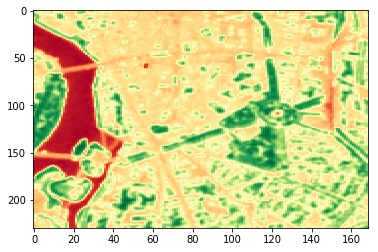

In [6]:
import matplotlib.pyplot as plt

plt.imshow(NDVI, cmap='RdYlGn', aspect='auto')

Finally we can save this picture and share it with who we want !

In [5]:
plt.savefig(os.path.join(workspace, 'ndvi_toulouse.png'))

<Figure size 432x288 with 0 Axes>